### Import packages

In [63]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Create function to calculate pvalues from a sklearn linear regression
- With thanks to JARH from stack overflow <br>
https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

In [64]:
def get_pvals(X_train, y_train):
    cols = np.array(X_train.columns.values)
    cols = np.insert(cols, 0, 'coef', axis=0)

    lm = LinearRegression()
    lm.fit(X_train, y_train)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X_train)

    newX = np.append(np.ones((len(X_train),1)), X_train, axis=1)
    MSE = (sum((y_train - predictions)**2)) / (len(newX) - len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    pvals = pd.DataFrame()
    pvals['feature'], pvals['coef'], pvals['standard_error'], pvals['t_vals'], pvals['pval'] = \
        [cols, params,sd_b,ts_b,p_values]
    
    return pvals

### Retrieve training data

In [65]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

In [66]:
def get_kill_col(X_train, y_train):
    # Get pvalues from get_pvals
    pval = get_pvals(X_train, y_train)
    
    # Identify column with highest pvalue
    kill_cols = pval[pval['pval'] == pval['pval'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['pval'].values
    
    return highest_p_col[0], highest_p[0]

### Loop get_kill_col to recursively remove lest significant features to model
- Loop terminates once the largest p-value in the regression is less than 0.05

In [67]:
xt = X_train
yt = y_train
p = 1
run = 1
results = {}

while p > 0.05:
        run_num = 'run{}'.format(run)
        high_col, high_p = get_kill_col(xt, yt)
        xt = xt.drop(columns=high_col)
        print('{}, column is {} with pval of {}'.format(run_num, high_col, high_p))    
        run += 1
        p = high_p

results;

run1, column is zipcode_98030 with pval of 0.916
run2, column is zipcode_98032 with pval of 0.84
run3, column is zipcode_98042 with pval of 0.773
run4, column is zipcode_98070 with pval of 0.441
run5, column is zipcode_98198 with pval of 0.356
run6, column is zipcode_98003 with pval of 0.311
run7, column is zipcode_98031 with pval of 0.21
run8, column is zipcode_98022 with pval of 0.05


### Capture columns to remove from the model and remove them

In [68]:
kill_cols = ['zipcode_98030', 'zipcode_98032', 'zipcode_98042', 'zipcode_98070',\
             'zipcode_98198', 'zipcode_98003', 'zipcode_98031']

X_train2 = X_train.drop(columns=kill_cols)

### Rerun the model and see if it improved

In [75]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train2)
pol_reg = LinearRegression()
poly_model = pol_reg.fit(X_poly, y_train);

poly_r2 = poly_model.score(X_poly, y_train)

In [76]:
poly_r2

0.9204106659930839

### Prior to feature removal, the r2 for the model equaled 0.919, although it is a small improvement, by removing seven zip codes, the r2 increased to 0.920

#### Now to rexamine visualizations

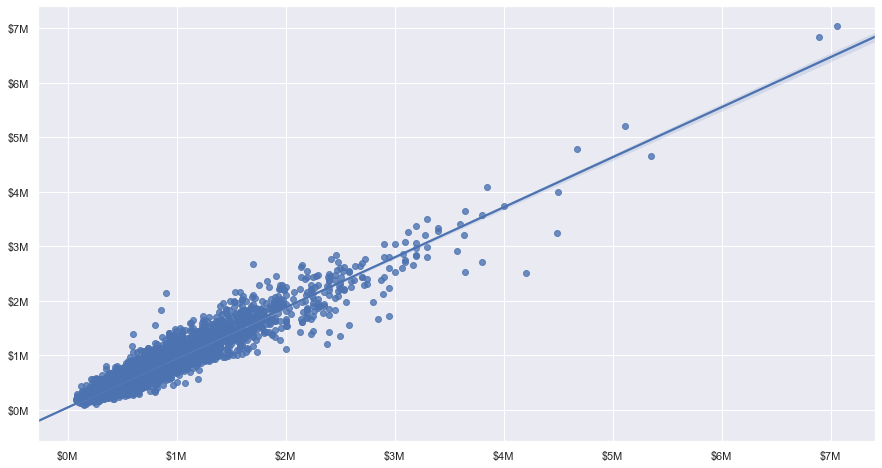

In [78]:
# Generate predicted values
y_pred_poly = pol_reg.predict(X_poly)

# Plot polynomial regression values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

poly = sns.regplot(x=y_train, y=y_pred_poly);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in poly.get_xticks()/1000000]
poly.set_xticklabels(xlabels);
poly.set_yticklabels(ylabels);

### ...and the regression graph

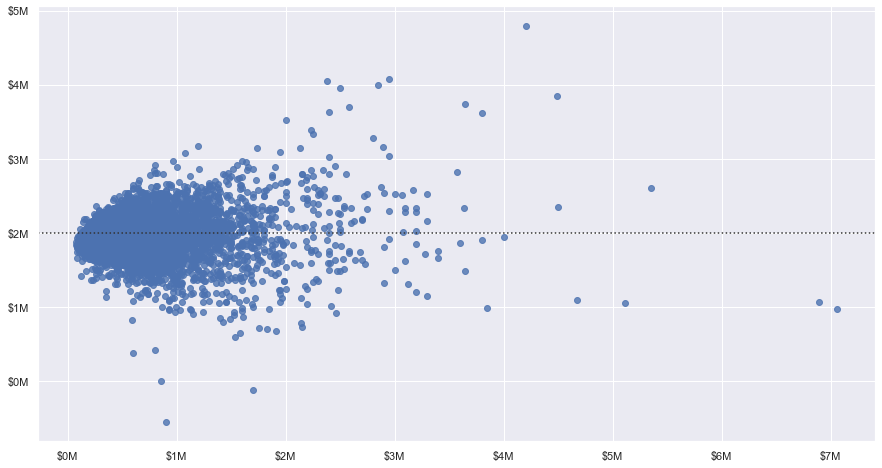

In [80]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred_poly

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid_poly = sns.residplot(x=xax, y=yax);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in resid_poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in resid_poly.get_xticks()/1000000]
resid_poly.set_xticklabels(xlabels);
resid_poly.set_yticklabels(ylabels);

### Export data

In [81]:
X_train2.to_csv('../data/X_train2.csv')

pickle_out = open('../data/poly_model_v2.pickle', 'wb')
pickle.dump(poly_model, pickle_out)